In [7]:
import os
import re
import torch
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# === Inicializar CodeBERT ===
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base", output_hidden_states=True)


/Users/luisgc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Embedding con CodeBERT
def get_embedding(text, capa=4):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Lista de 13 tensores (incluye embedding inicial)
    capa_oculta = hidden_states[capa]      # Selecciona la capa que quieras

    # Tomamos el vector del token [CLS] de esa capa
    return capa_oculta[:, 0, :].squeeze().numpy()

In [9]:
# === Función para anonimizar código ===
def anonimizar_codigo(code):
    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', code)
    usados = {}
    nuevo_codigo = code
    contador = 1
    for tok in tokens:
        if tok not in usados and tok not in {"def", "if", "else", "for", "while", "return", "print", "input"}:
            usados[tok] = f"VAR_{contador}"
            contador += 1
    for original, nuevo in usados.items():
        nuevo_codigo = re.sub(rf'\b{original}\b', nuevo, nuevo_codigo)
    return nuevo_codigo

In [10]:
# === Extraer todas las funciones de un archivo ===
def extraer_todas_funciones(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()
    funciones = re.findall(r"(def\s+[a-zA-Z_][a-zA-Z0-9_]*\(.*?\):(?:\n(?:\s{4}|\t).*)*)", code)
    return funciones if funciones else [code]

In [11]:
import os
import numpy as np
import re
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def ratio_similitud_bruta(c1, c2):
    return SequenceMatcher(None, c1, c2).ratio()

def contar_identificadores(cod1, cod2):
    tokens1 = set(re.findall(r'\b[a-zA-Z_]\w*\b', cod1))
    tokens2 = set(re.findall(r'\b[a-zA-Z_]\w*\b', cod2))
    comunes = tokens1 & tokens2
    dif = (tokens1 | tokens2) - comunes
    return len(dif)

def lineas_iguales(c1, c2):
    l1 = set(c1.splitlines())
    l2 = set(c2.splitlines())
    return len(l1 & l2)

def features_por_par(path1, path2):
    if not os.path.exists(path1) or not os.path.exists(path2):
        return None

    funcs1 = extraer_todas_funciones(path1)
    funcs2 = extraer_todas_funciones(path2)

    # Anonimizamos funciones
    funcs1_anon = [anonimizar_codigo(f) for f in funcs1]
    funcs2_anon = [anonimizar_codigo(f) for f in funcs2]

    # Embeddings con CodeBERT (por función)
    emb1 = [get_embedding(f, capa=4) for f in funcs1_anon]
    emb2 = [get_embedding(f, capa=4) for f in funcs2_anon]

    if not emb1 or not emb2:
        return None

    # Distancias Euclidianas negativas entre todas las combinaciones
    distancias = [-euclidean(e1, e2) for e1 in emb1 for e2 in emb2]

    max_sim = max(distancias)
    avg_sim = np.mean(distancias)
    count_95 = sum(1 for s in distancias if s > -0.05)
    count_90 = sum(1 for s in distancias if s > -0.1)

    # Texto original y anonimizado completo
    all_code1 = " ".join(funcs1_anon)
    all_code2 = " ".join(funcs2_anon)
    raw_code1 = " ".join(funcs1)
    raw_code2 = " ".join(funcs2)

    # TF-IDF similarity (cosine)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([all_code1, all_code2])
    sim_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    # Métricas adicionales
    sim_bruta = ratio_similitud_bruta(raw_code1, raw_code2)
    idf_diff = contar_identificadores(raw_code1, raw_code2)
    lineas_eq = lineas_iguales(raw_code1, raw_code2)

    return [
        max_sim, avg_sim, count_95, count_90,
        len(emb1), len(emb2), sim_tfidf,
        sim_bruta, idf_diff, lineas_eq
    ]

In [ ]:
def preprocesar_pares(csv_path, save_path="dataset_features.npz"):
    df = pd.read_csv(csv_path)
    X, y = [], []

    for _, row in df.iterrows():
        path1, path2, etiqueta = row["codigo_1"], row["codigo_2"], row["tipo_plagio"]
        if etiqueta != 4:
            feats = features_por_par(path1, path2)
            if feats is not None:
                X.append(feats)
                y.append(etiqueta)

    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    np.savez_compressed(save_path, X=X, y=y)
    print(f"Dataset procesado y guardado en {save_path} con {len(X)} pares.")

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

def fijar_semillas(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fijar_semillas()


class PlagioNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PlagioNet, self).__init__()

        self.net = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ELU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3),

        nn.Linear(128, 64),
        nn.ELU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.2),

        nn.Linear(64, 32),
        nn.ELU(),

        nn.Linear(32, num_classes)
    )

    def forward(self, x):
        return self.net(x)
    
def entrenar_red_desde_npz(npz_path, epochs=101):
    datos = np.load(npz_path)
    X = datos["X"]
    y = datos["y"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=16, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=16)

    model_nn = PlagioNet(input_size=X.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs):
        model_nn.train()
        total, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_nn(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accs.append(correct / total)

        # Test acc por epoch
        model_nn.eval()
        correct_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_nn(inputs)
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
        test_accs.append(correct_test / len(X_test))

        print(f"Epoch {epoch:03d} | Train Acc: {train_accs[-1]:.4f} | Test Acc: {test_accs[-1]:.4f}")

    # Evaluación final
    all_preds, all_labels, all_probs = [], [], []
    model_nn.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model_nn(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            _, preds = torch.max(probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n=== Reporte de Clasificación ===")
    print(classification_report(all_labels, all_preds, target_names=[str(c) for c in le.classes_]))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(c) for c in le.classes_])
    disp.plot(cmap="Blues", values_format="d")
    plt.show()

    # Gráfica de accuracy entrenamiento vs prueba
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel("Época")
    plt.ylabel("Precisión")
    plt.title("Precisión en Entrenamiento vs Prueba")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    input_size = X.shape[1]
    torch.save({
        'model_state_dict': model_nn.state_dict(),
        'input_size': input_size,
        'num_classes': num_classes,
        'label_encoder': le.classes_.tolist(),
        'dropout_1_2': 0.5,
        'dropout_3': 0.2,
        'timestamp': '2025-05-29 16:23',
        'accuracy': 0.912,
        'macro_f1': 0.87
    }, "modelT.pth")

    return model_nn, le, X_test, y_test, all_preds, all_probs


In [120]:
# preprocesar_pares("pares_balanceado.csv", "dataset_features_balanceado.npz")

Epoch 001 | Train Acc: 0.6516 | Test Acc: 0.7315
Epoch 002 | Train Acc: 0.7210 | Test Acc: 0.7646
Epoch 003 | Train Acc: 0.7703 | Test Acc: 0.7996
Epoch 004 | Train Acc: 0.7911 | Test Acc: 0.8366
Epoch 005 | Train Acc: 0.7928 | Test Acc: 0.8444
Epoch 006 | Train Acc: 0.8028 | Test Acc: 0.8502
Epoch 007 | Train Acc: 0.8079 | Test Acc: 0.8502
Epoch 008 | Train Acc: 0.8062 | Test Acc: 0.8502
Epoch 009 | Train Acc: 0.8212 | Test Acc: 0.8444
Epoch 010 | Train Acc: 0.8095 | Test Acc: 0.8444
Epoch 011 | Train Acc: 0.8062 | Test Acc: 0.8424
Epoch 012 | Train Acc: 0.8129 | Test Acc: 0.8424
Epoch 013 | Train Acc: 0.8120 | Test Acc: 0.8502
Epoch 014 | Train Acc: 0.8137 | Test Acc: 0.8463
Epoch 015 | Train Acc: 0.8304 | Test Acc: 0.8482
Epoch 016 | Train Acc: 0.8246 | Test Acc: 0.8541
Epoch 017 | Train Acc: 0.8429 | Test Acc: 0.8580
Epoch 018 | Train Acc: 0.8262 | Test Acc: 0.8502
Epoch 019 | Train Acc: 0.8421 | Test Acc: 0.8482
Epoch 020 | Train Acc: 0.8346 | Test Acc: 0.8580
Epoch 021 | Train Ac

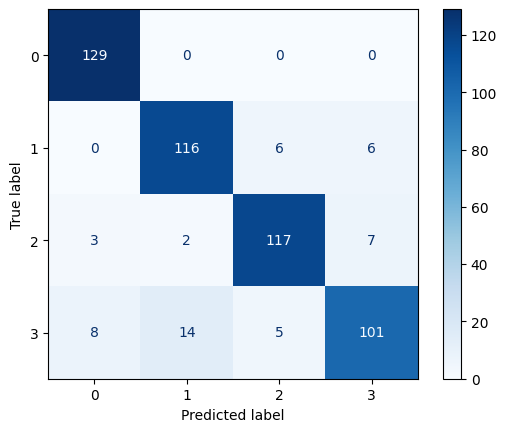

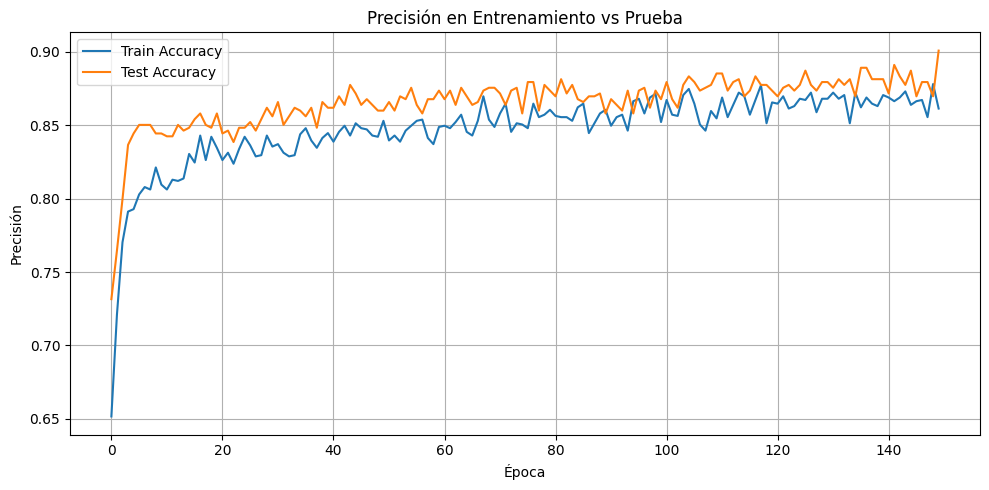

In [119]:
model1, le, X_test, y_test, preds, probs = entrenar_red_desde_npz("dataset_features_balanceado.npz", 151)

In [121]:
def predecir_par(model, label_encoder, path1, path2):
    feats = features_por_par(path1, path2)
    if feats is None:
        print("No se pudo procesar el par")
        return
    x = torch.tensor(feats, dtype=torch.float32).unsqueeze(0)  # batch=1
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    
    for idx, prob in enumerate(probs):
        print(f"Tipo {label_encoder.inverse_transform([idx])[0]}: {prob*100:.2f}%")


In [122]:
predecir_par(model1, le, "dataset/par-1-a-juego-puntuacion.py", "dataset/par-45-d-analizador-palabras.py")

Tipo 0: 99.29%
Tipo 1: 0.03%
Tipo 2: 0.15%
Tipo 3: 0.52%


In [129]:
predecir_par(model1, le, "dataset/par-45-a-analizador-palabras.py", "dataset/par-45-c-analizador-palabras.py")

Tipo 0: 0.02%
Tipo 1: 21.00%
Tipo 2: 26.48%
Tipo 3: 52.50%


In [127]:
predecir_par(model1, le, "dataset/par-22-a-Greedy.py", "dataset/par-22-c-Greedy.py")

Tipo 0: 0.01%
Tipo 1: 23.32%
Tipo 2: 0.86%
Tipo 3: 75.80%
